In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
MATRES_DATA_PATH = Path('../data')

In [9]:
aquaint_df = pd.read_csv(MATRES_DATA_PATH / 'aquaint.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])
aquaint_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,NYT20000406.0002,said,made,1,2,AFTER
1,NYT20000406.0002,made,raised,2,5,AFTER
2,NYT20000406.0002,left,stir,17,19,EQUAL
3,NYT20000406.0002,left,demanded,17,21,BEFORE
4,NYT20000406.0002,stir,demanded,19,21,BEFORE
...,...,...,...,...,...,...
6399,APW19980911.0475,transferred,transported,28,31,VAGUE
6400,APW19980911.0475,said,exploded,29,30,AFTER
6401,APW19980911.0475,said,transported,29,31,AFTER
6402,APW19980911.0475,exploded,transported,30,31,BEFORE


In [5]:
platinum_df = pd.read_csv(MATRES_DATA_PATH / 'platinum.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])
platinum_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,WSJ_20130322_159,apologized,happened,1,5,VAGUE
1,WSJ_20130322_159,apologized,wrapped,1,6,BEFORE
2,WSJ_20130322_159,apologized,seemed,1,10,BEFORE
3,WSJ_20130322_159,apologized,yield,1,11,VAGUE
4,WSJ_20130322_159,happened,wrapped,5,6,BEFORE
...,...,...,...,...,...,...
832,CNN_20130322_248,sparing,begin,3,6,BEFORE
833,CNN_20130322_248,sparing,said,3,7,EQUAL
834,CNN_20130322_248,expected,begin,4,6,BEFORE
835,CNN_20130322_248,expected,said,4,7,BEFORE


In [6]:
timebank_df = pd.read_csv(MATRES_DATA_PATH / 'timebank.txt', sep='\t', header=None,
                         names=['docid', 'verb1', 'verb2', 'eiid1', 'eiid2', 'relation'])
timebank_df

,docid,verb1,verb2,eiid1,eiid2,relation
0,ABC19980120.1830.0957,predicted,tried,415,417,BEFORE
1,ABC19980120.1830.0957,predicted,hasten,415,418,BEFORE
2,ABC19980120.1830.0957,tried,hasten,417,418,VAGUE
3,ABC19980120.1830.0957,predicted,endures,415,419,BEFORE
4,ABC19980120.1830.0957,tried,endures,417,419,BEFORE
...,...,...,...,...,...,...
6331,wsj_0586,closed,cited,1511,1515,BEFORE
6332,wsj_0586,mixed,cited,1513,1515,BEFORE
6333,wsj_0586,cited,closed,1515,1517,AFTER
6334,wsj_0586,closed,caused,1517,1521,AFTER


In [23]:
from functools import reduce

supported_relation = ['AFTER', 'BEFORE']

def create_edges(df):
    edges_df = pd.DataFrame()
    edges_df[['source', 'target']] = df[['docid', 'eiid1', 'eiid2', 'relation']] \
        .apply(lambda row: (f"{row.docid}-{row['eiid2']}" ,f"{row.docid}-{row['eiid1']}")
                if row['relation'] == 'AFTER' else (f"{row.docid}-{row['eiid1']}" , f"{row.docid}-{row['eiid2']}"),
               axis='columns', result_type="expand")
    return edges_df

def create_nodes(df):
    nodes_raw_df = df.apply(lambda row: [dict(docid=row.docid, verb=row.verb1, eiid=f"{row.docid}-{row.eiid1}"),
                                  dict(docid=row.docid, verb=row.verb2, eiid=f"{row.docid}-{row.eiid2}")], axis='columns').to_list()
    nodes_flatten = reduce(lambda x, y: x+y, nodes_raw_df)
    return pd.DataFrame(nodes_flatten).drop_duplicates(ignore_index=True)

def generate_directed_graph(df, relations=supported_relation):
    df = df.loc[df['relation'].isin(relations)]
    edges = create_edges(df)
    nodes = create_nodes(df)

    # G = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph)
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.docid)), 'docid')
    nx.set_node_attributes(G, dict(zip(nodes.eiid, nodes.verb)), 'verb')
    return G

def generate_subgraph_by_docid(graph, doc_id):
    sub_graph = []
    for (n, data) in graph.nodes(data=True):
      if data['docid'] == doc_id:
        sub_graph.append(n)
    
    return graph.subgraph(sub_graph).copy()

In [17]:
def draw_directed_graph(graph):
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = (15,10)

    labels = nx.get_node_attributes(graph, 'verb') 
    pos = nx.circular_layout(graph)
    
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=labels)
    nx.draw_networkx_edges(
        graph, 
        pos, 
        arrows=True,
        edgelist=graph.edges(), 
        edge_color='blue', 
        width=3, 
        label="S", 
        arrowstyle='-|>')
    
    # plt.legend(fontsize = 'medium')
    plt.show()

In [41]:
def find_cycles(df):
    idx = 0
    for _, group in df.groupby('docid'):
        if group.relation.isin(supported_relation).count() < 3:
            continue
        try:
            sub_graph = generate_directed_graph(df=group)
            cycle = nx.find_cycle(sub_graph, orientation='original')
            print('cycle:', cycle)
        except nx.NetworkXNoCycle:
            idx += 1
        except ValueError:
            print(group)
        else:
            if cycle is not None:
                print(cycle)
            if idx > 2:
                return cycle
            

In [42]:
find_cycles(platinum_df)

In [43]:
find_cycles(aquaint_df)

In [44]:
find_cycles(timebank_df)

In [45]:
sample_g = nx.DiGraph([('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'f'), ('f', 'a')])

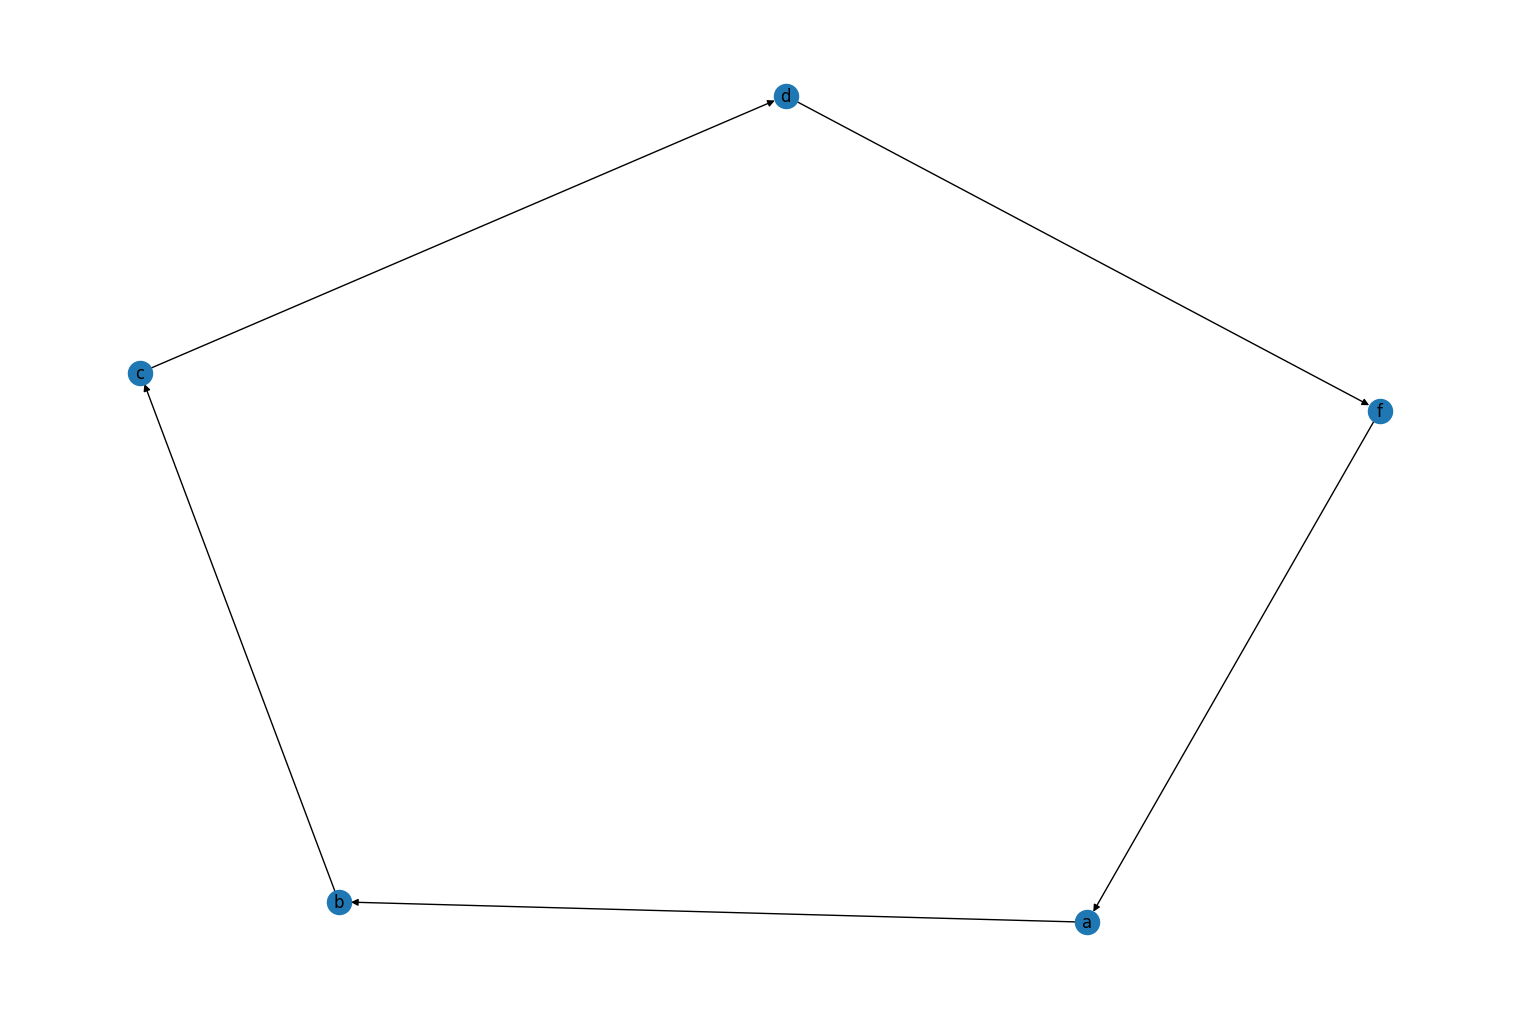

In [46]:
nx.draw(sample_g, with_labels=True)

In [47]:
cycle = nx.find_cycle(sample_g, orientation='original')

In [48]:
cycle

[('a', 'b', 'forward'),
 ('b', 'c', 'forward'),
 ('c', 'd', 'forward'),
 ('d', 'f', 'forward'),
 ('f', 'a', 'forward')]